In [ ]:
from Basefolder import basefolder
import time
import numpy as np
import pandas as pd
from Finder_1d import Finder_1d
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import seaborn as sns
from sklearn.cluster import DBSCAN
from Clustering_CAML import Clustering_CAML
import h5py
from DbscanLoop import DbscanLoop
from sklearn.neighbors import NearestNeighbors
import pickle
import scipy.stats as stats

from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import PlotScatter
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import LoadPoints
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import FilterPoints
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetLineOfOptima
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetLineOfOptimaUnique
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetClusterDistribution
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetClusterSizesAlongOptima
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import AnalyseClusterSizes
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import PlotDistribution

pd.options.mode.chained_assignment = None  # default='warn'

# Parameters

In [15]:
loadCase              = "TTX"; #Mike
loadComputeClustering = "load";

# Load Points

In [ ]:
parameters = {'outputfolder':,\
             };

In [4]:
if(loadCase == "TTX"):
    mainfolder     = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/ProteinData_ttx_1hr_2/';    
    analysis_name  = "dataWindow_2";
    image_filename = "AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20";
                      'AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20_X_noise.txt

    XC        = LoadPoints(mainfolder+image_filename+'.hdf5',datascale=158);    
    XC_signal = FilterPoints(XC,22000,27000,22000,27000);
    XC_noise  = FilterPoints(XC,60000,70000,50000,60000);

elif(loadCase == "Mike"):
    mainfolder       = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/MikeData/';    
    image_filename   = 'EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma_X';
    
    if(True):
        analysis_name = "dataWindow_1";    
        algo          = "DbscanLoop"
    else:    
        analysis_name = "dataWindow_1_dbscan";    
        algo          = "dbscan"
    
    XC_noise     = LoadPoints(mainfolder+image_filename+'_noise.txt');
    XC_signal    = LoadPoints(mainfolder+image_filename+'_signal.txt');    
    
    XC_noise  = FilterPoints(XC_noise,50,60,50,60)
    XC_signal = FilterPoints(XC_signal,100,110,150,160)    
    #Define window to analyse
    
outputfolder   = mainfolder + 'Analysis/';    
outputfolder_R = mainfolder + 'Output_R/';
save_name      = outputfolder+analysis_name;
np.savetxt(save_name+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");
np.savetxt(save_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    

In [5]:
#XC_noise     = LoadPoints(mainfolder+'EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma_X_noise.txt');
#XC_noise  = FilterPoints(XC_noise,60,80,60,80)

Plot Overview

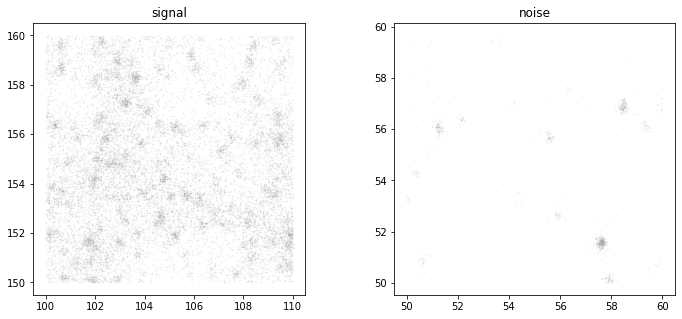

In [6]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
PlotScatter(XC_signal,ax=axs[0])
PlotScatter(XC_noise,ax=axs[1])
#np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    
axs[0].set_title('signal');
axs[1].set_title('noise');

plt.savefig(save_name+"_localizations_signal_vs_noise.pdf",bbox_inches="tight");

# Load or compute clustering

In [7]:
if(loadComputeClustering == "compute"):
    FD      = Finder_1d(algo=algo);
    labels  = FD.fit(XC_signal);    
    
    FD_ref      = Finder_1d(algo=algo);
    labels_ref  = FD_ref.fit(XC_noise,XC_signal);    
    
    with open(outputfolder+"results_"+analysis_name+'.pickle','wb') as handle:
        pickle.dump({'FD':FD,'FD_ref':FD_ref}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
elif(loadComputeClustering == "load"):
    filename = outputfolder+'results_'+analysis_name+'.pickle';
    with open(filename, 'rb') as fr:
        FD_load = pickle.load(fr);
    FD     = FD_load['FD'];
    FD_ref = FD_load['FD_ref'];
    print("Loaded Clustering results from "+filename);
else:
    print("ERROR");

Loaded Clustering results from /Users/andreas/Documents/NoiseRecognizer_WorkingVersion/MikeData/Analysis/results_dataWindow_1.pickle


In [8]:
df1     = FD.phasespace[['sigma', 'threshold','similarityScore','no_clusters']];
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore','no_clusters']];

df1['similarityScore_ref']       = df1_ref['similarityScore'];
df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);

df1['no_clusters_ref']       = df1_ref['no_clusters'];
df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);

df_opt_sim = GetLineOfOptima(df1,'similarityScore_ref','similarityScore',15);
df_opt_cl  = GetLineOfOptima(df1,'no_clusters_ref','no_clusters',15);

# Analysis
## Heatmaps Similiarity Score and Number of Clusters

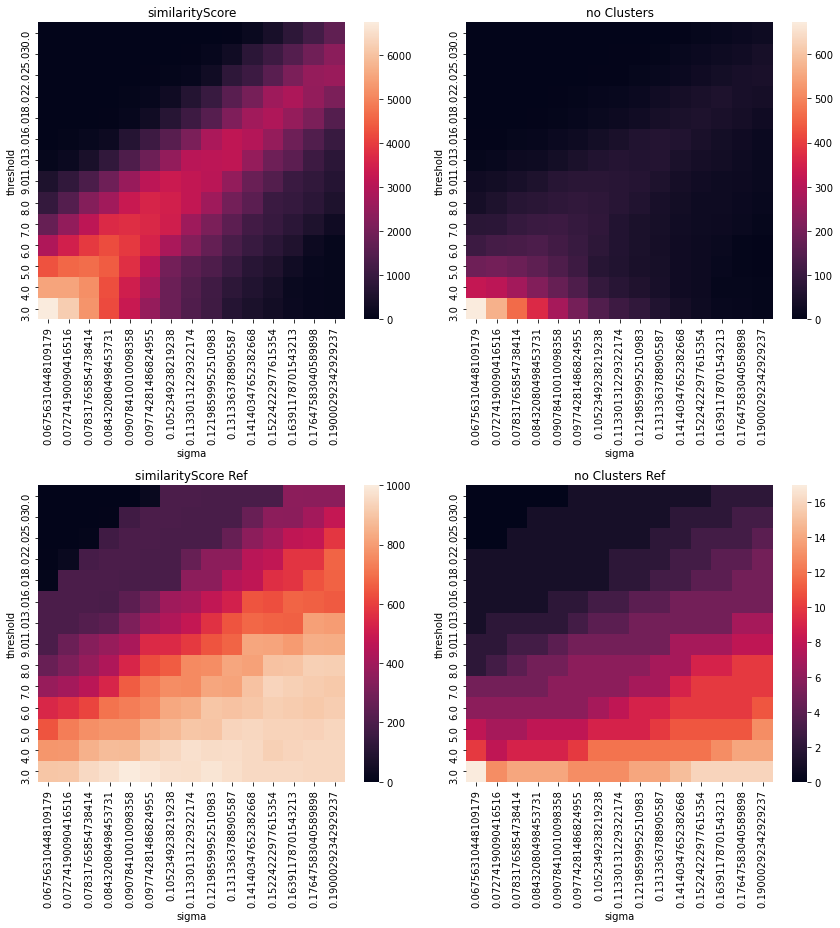

In [9]:
fig,axs = plt.subplots(2,2,figsize=(12,13));


heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,0]);
ax.invert_yaxis()
ax.set_title('similarityScore');

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,1]);
ax.invert_yaxis()
ax.set_title('no Clusters');

heatmap1_data = pd.pivot_table(df1_ref, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,0]);
ax.invert_yaxis()
ax.set_title('similarityScore Ref');

heatmap1_data = pd.pivot_table(df1_ref, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,1]);
ax.invert_yaxis()
ax.set_title('no Clusters Ref');

fig.tight_layout();
plt.savefig(save_name+"_PhaseSpaces.pdf",bbox_inches="tight");

## Analyse Line Of Optima of signal

In [10]:
df_opt_th     = GetLineOfOptima(df1,'threshold','similarityScore')
df_opt_th_ncl = GetLineOfOptima(df1,'threshold','no_clusters')

df_clusterSizes     = GetClusterSizesAlongOptima(FD,df_opt_th);
df_clusterSizes_ref = GetClusterSizesAlongOptima(FD_ref,df_opt_th);

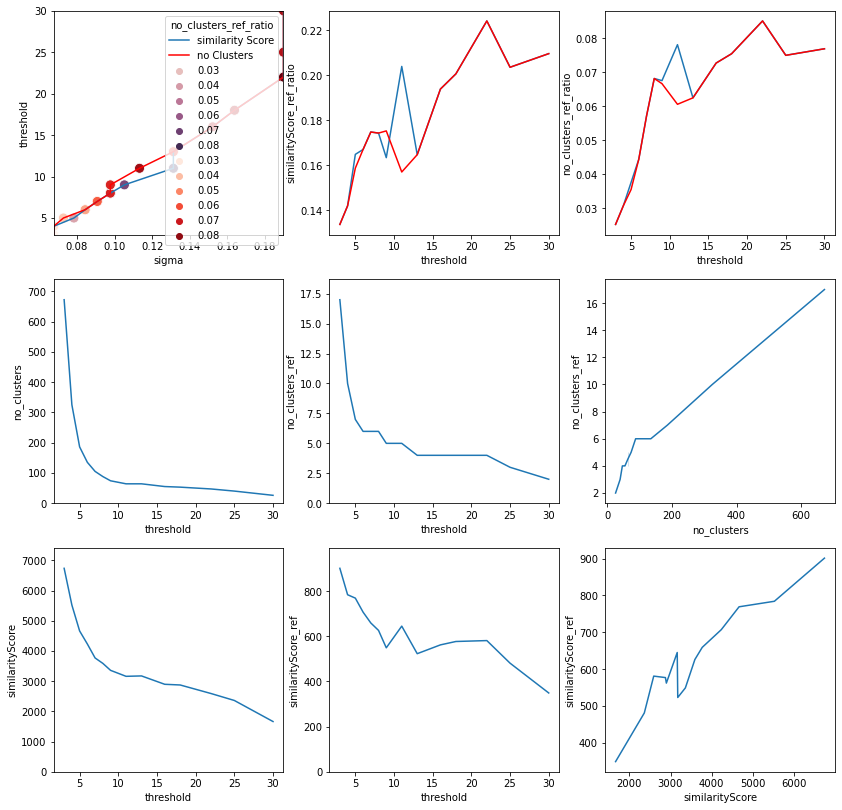

In [11]:
fig,axs = plt.subplots(3,3,figsize=(14,14));

ax = axs[0,0];
ax.plot(df_opt_th['sigma'],df_opt_th['threshold'],label='similarity Score');
sns.scatterplot(x=df_opt_th['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],s=100,ax=ax);

ax.plot(df_opt_th_ncl['sigma'],df_opt_th_ncl['threshold'],'r',label='no Clusters');
sns.scatterplot(x=df_opt_th_ncl['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],\
                s=100,ax=ax,palette='Reds');

ax.set_xlim(np.min(df1['sigma']),np.max(df1['sigma']))
ax.set_ylim(np.min(df1['threshold']),np.max(df1['threshold']))

ax = axs[0,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='similarityScore_ref_ratio',ax=ax,color='r');

ax = axs[0,2];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='no_clusters_ref_ratio',ax=ax,color='r');

ax = axs[1,0];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters']));

ax = axs[1,1];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters_ref']));

ax = axs[1,2];
sns.lineplot(data=df_opt_th,x='no_clusters',y='no_clusters_ref',ax=ax);

ax = axs[2,0];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore']));

ax = axs[2,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore_ref']));

ax = axs[2,2];
sns.lineplot(data=df_opt_th,x='similarityScore',y='similarityScore_ref',ax=ax);

plt.savefig(save_name+"_Analysis_alongLineOfOptima.pdf",bbox_inches="tight");

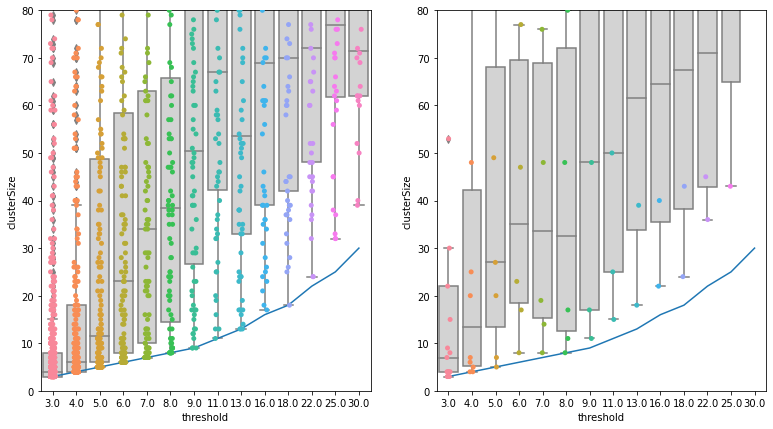

In [12]:
PlotDistribution(df_clusterSizes,df_clusterSizes_ref,save_name+"_clusterDistribution_alongLineOfOptima_signal.pdf");

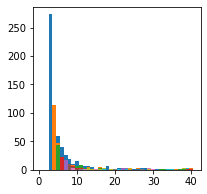

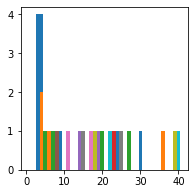

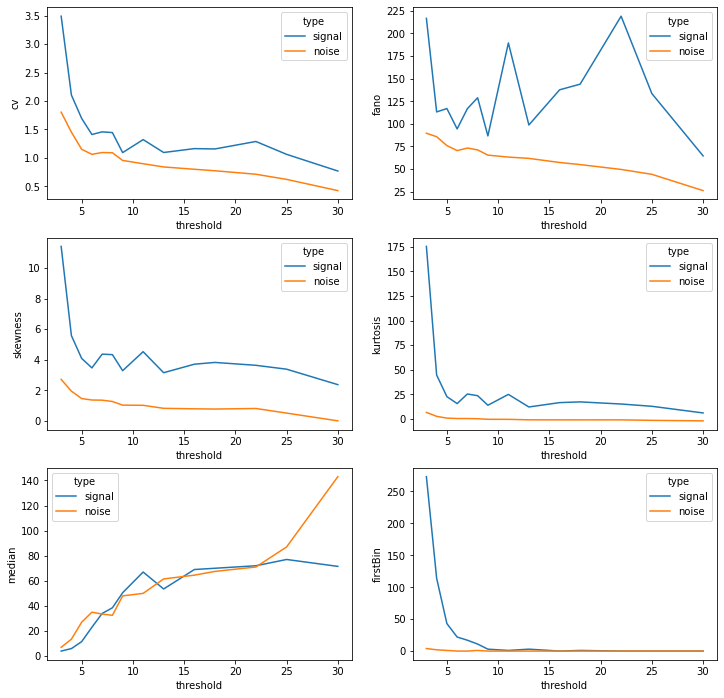

In [13]:
df_stats_per_th = AnalyseClusterSizes(df_clusterSizes,df_clusterSizes_ref,save_name+"_phasespace_alongLineOfOptima.pdf");

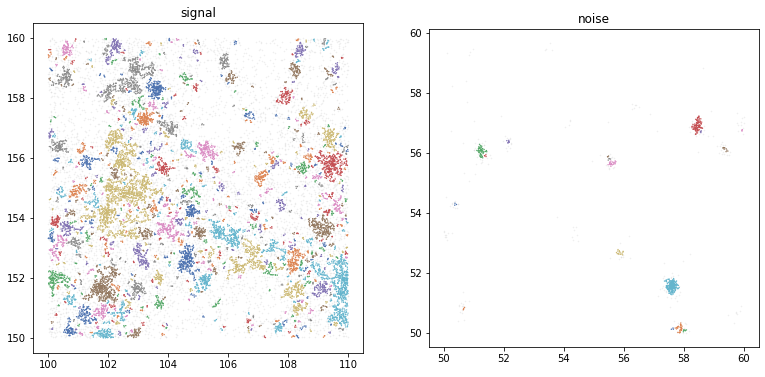

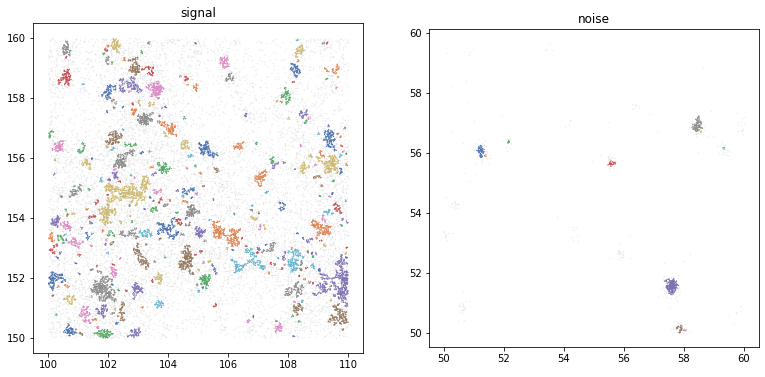

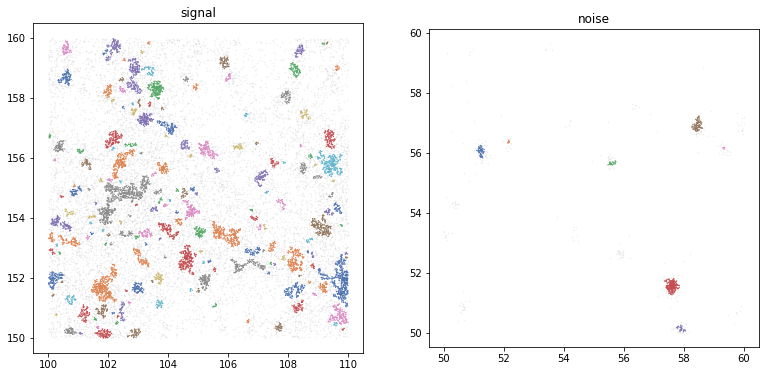

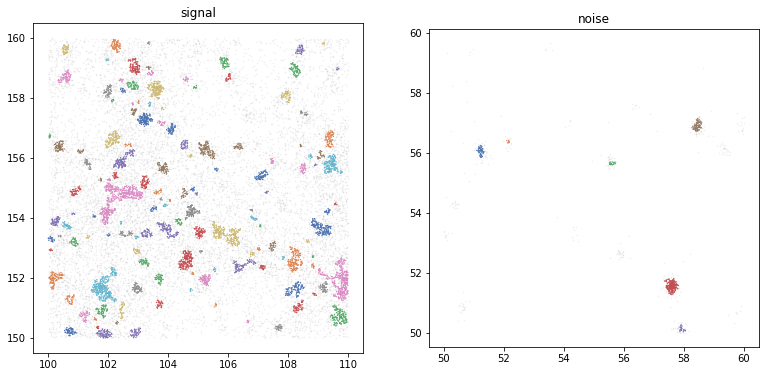

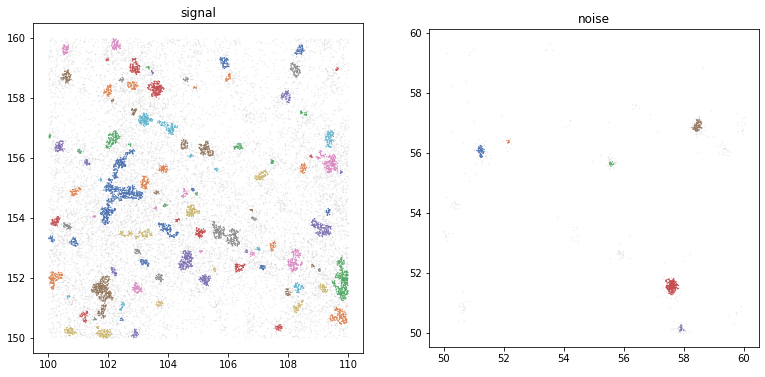

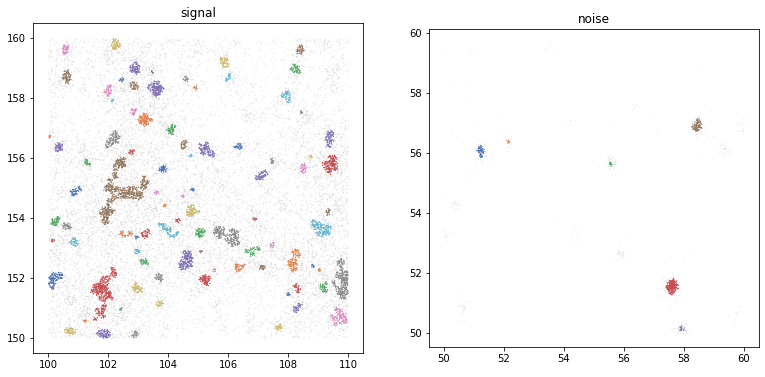

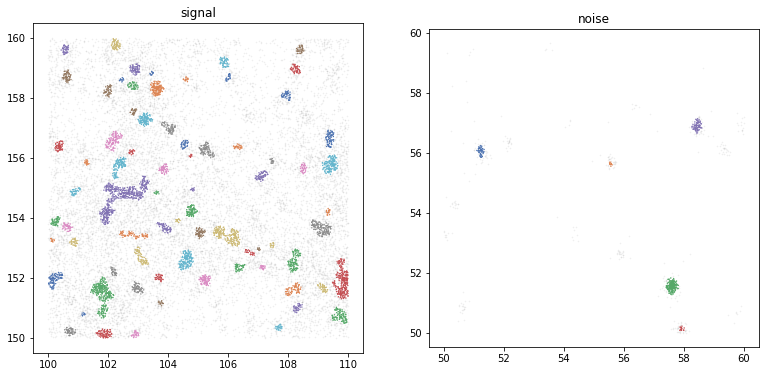

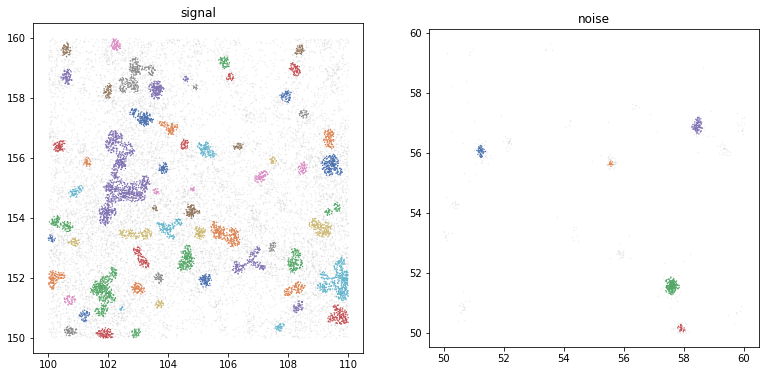

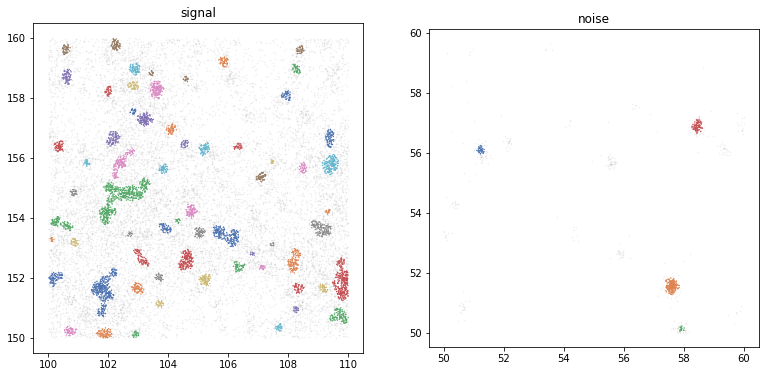

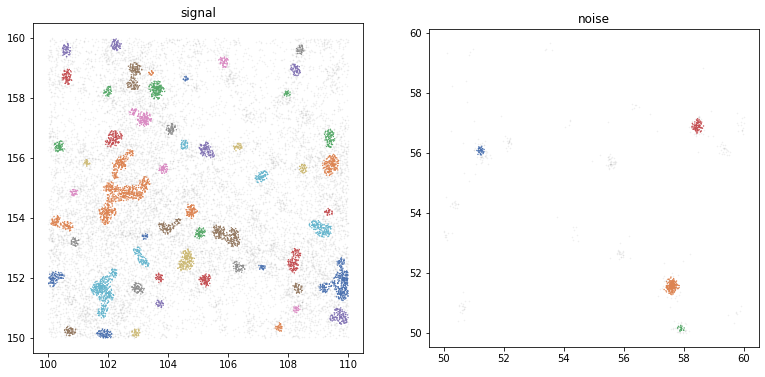

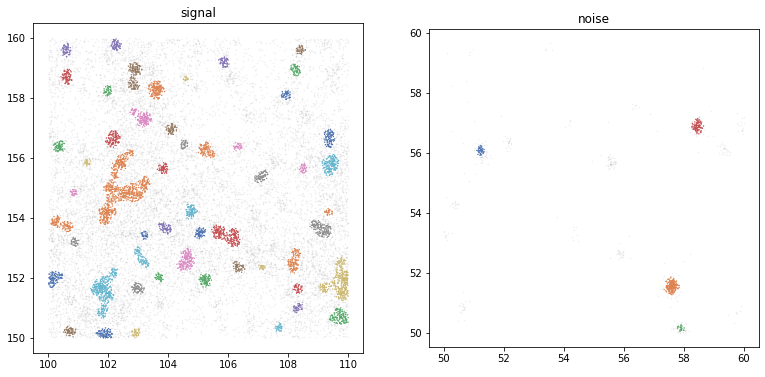

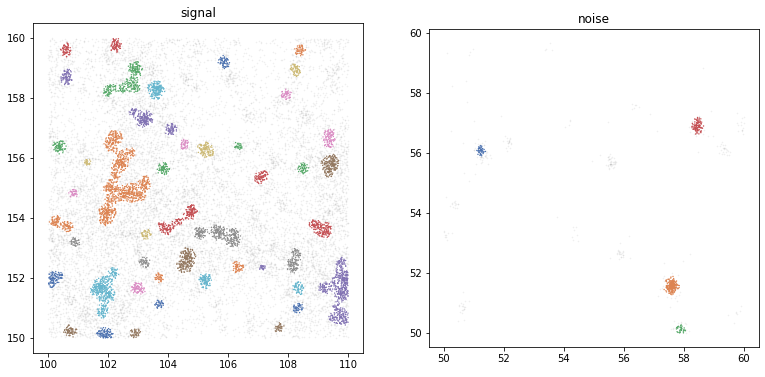

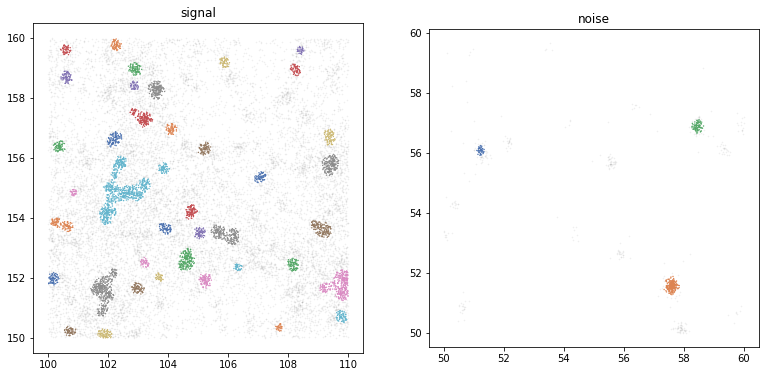

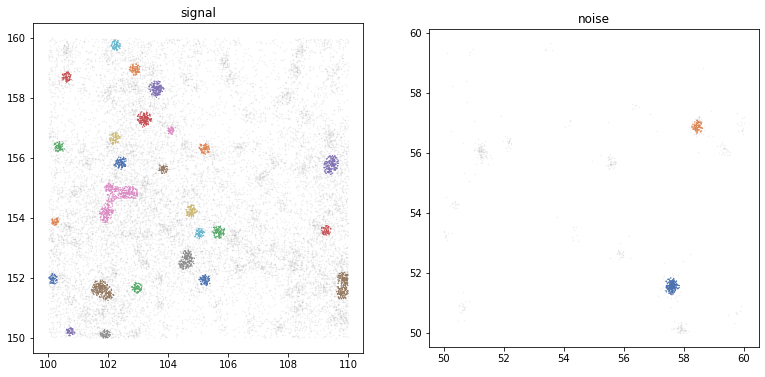

In [14]:
for th in np.unique(df_opt_th['threshold']):
    idx_ = int(df_opt_th.loc[df_opt_th['threshold']==th,'idx'])

    fig,axs = plt.subplots(1,2,figsize=(13,8)); 
    PlotScatter(XC_signal,FD.phasespace.loc[idx_,'labels'],ax=axs[0])
    PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_,'labels'],ax=axs[1])
    axs[0].set_title('signal');
    axs[1].set_title('noise');
    plt.savefig(save_name+"_OptimalClustering_threshold_"+str(th)+".pdf",bbox_inches="tight");

## Analyse signal vs noise

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='similarityScore_ref',y="similarityScore",color='r',ax=ax)
sns.lineplot(data=df_opt_cl,x='similarityScore_ref',y="similarityScore",color='b',ax=ax)
ax.set_title('ordered by similarity score');

ax      = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='no_clusters_ref',y="no_clusters",ax=ax,color='r')
sns.lineplot(data=df_opt_cl,x='no_clusters_ref',y="no_clusters",ax=ax,color='b')
ax.set_title('ordered by no of clusters');

plt.savefig(save_name+"_phasespace_ordered.pdf",bbox_inches="tight");
#ax.set_xlim(-10,2000);
#ax.set_xlim(0,30);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref_ratio',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref_ratio'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref_ratio'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
ax.set_xlim(0,1);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref_ratio',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref_ratio'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref_ratio'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
ax.set_xlim(0,0.5);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='no_clusters_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
#ax.set_xlim(-1,20);
#ax.set_ylim(-1,50);

# Save for input in R 

In [ ]:
#Save phasespace in csv
FD_all1 = (FD.phasespace);
FD_all1['type'] = 'signal';

FD_all2         = (FD_ref.phasespace);
FD_all2['type'] = 'noise';

(FD_all1.append(FD_all2,ignore_index=True)).to_csv(outputfolder_R+'results_'+analysis_name+'.csv');
#(FD.phasespace).to_csv(outputfolder+'results_phasespace'+analysis_name+'.csv');

In [ ]:
L = np.zeros((len((FD.phasespace).loc[1,'labels']),len(FD.phasespace)),dtype=np.int32)
for i,d in enumerate(FD.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_signal.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [ ]:
L = np.zeros((len((FD_ref.phasespace).loc[1,'labels']),len(FD_ref.phasespace)),dtype=np.int32)
for i,d in enumerate(FD_ref.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_noise.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [ ]:
np.savetxt(outputfolder_R+analysis_name+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");
np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    

In [ ]:
cls_distribution = [];
ind = np.zeros((0,),dtype=int);
for i,d in enumerate(FD.phasespace['labels']):
    d_ = GetClusterDistribution(d);
    cls_distribution += (d_);
    ind = np.concatenate((ind,i*np.ones_like(d_,dtype=int)))
    
cls_d = pd.DataFrame();
cls_d['size'] = cls_distribution
cls_d['index'] = (ind);
cls_d.to_csv(outputfolder_R+analysis_name+"_clusterSizes.txt")

In [ ]:
#with open(outputfolder_R+analysis_name+"_clusterSizes.txt", "w") as txt_file:
#    for i,d in enumerate(FD.phasespace['labels']):
#        d_ = GetClusterDistribution(d);
#        txt_file.write(' '.join(str(x) for x in d_)+'\n') # works with any number of el

# Analysis

In [ ]:
#Select a clustering:
if(False):
    limit_noise_to_signal = 0.4;
    
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref_ratio'] < limit_noise_to_signal);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref_ratio'] < limit_noise_to_signal);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])
else:
    limit_noise_no_cluster = 4;    
    limit_noise_similarity = 320;
        
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref'] < limit_noise_similarity);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref'] < limit_noise_no_cluster);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(13,13)); 
PlotScatter(XC_signal,FD.phasespace.loc[idx_similarityScore,'labels'],ax=axs[0,0])
PlotScatter(XC_signal,FD.phasespace.loc[idx_no_clusters,'labels'],ax=axs[0,1])

PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_similarityScore,'labels'],ax=axs[1,0])
PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_no_clusters,'labels'],ax=axs[1,1])

In [ ]:
# Analysis: Did we reach a plateau?
def Plateau_analysis(x,y):    
    x =np.asarray(x);
    y =np.asarray(y);    
    
    y = 0.5*(y[1:]+y[:-1]);
    x = 0.5*(x[1:]+x[:-1]);    
    
    dydx = (y[1:]-y[:-1])/(x[1:]-x[:-1]);
#    print(dydx)
#    print(y)
    plt.plot(x[1:],dydx/y[0],'r');
#    plt.plot(x,y,'b');

In [ ]:
Plateau_analysis(df_stats_per_th['threshold'],df_stats_per_th['firstBin'])
plt.xlim(0,20)

In [ ]:
z = df_stats_per_th['kurtosis'];
sns.lineplot(df_stats_per_th['threshold'][1:],np.abs(np.asarray(z[1:])-np.asarray(z[:-1])),label='kurtosis');

In [ ]:
np.arange(np.max(df_clusterSizes['threshold']))

In [ ]:
sns.histplot(df_clusterSizes.loc[df_clusterSizes['threshold']==11,'clusterSize'],bins=np.linspace(0,100,101)+0.5)

In [ ]:
plt.plot(df_opt_sim['sigma'],df_opt_sim['threshold']);
sns.scatterplot(x=df_opt_sim['sigma'],y=df_opt_sim['threshold'],hue=df_opt_sim['similarityScore'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
plt.plot(df_opt_cl['sigma'],df_opt_cl['threshold']);
sns.scatterplot(x=df_opt_cl['sigma'],y=df_opt_cl['threshold'],hue=df_opt_cl['no_clusters'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
df1['no_clusters_diff'] = np.asarray(df1.loc[:,'no_clusters'])-np.asarray(df1_ref.loc[:,'no_clusters'])
df1 = df1.fillna(0)

fig,axs = plt.subplots(1,2,figsize=(12,5));

heatmap1_data = pd.pivot_table(df1, values='no_clusters_diff', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1]);
ax.invert_yaxis()

In [ ]:
for th in np.unique(FD.phasespace['threshold']):
    mark = (FD.phasespace['threshold'] == th);
    PS_sel = FD.phasespace.loc[mark,:];
    idx_max = PS_sel['similarityScore'].idxmax();
    PlotScatter(XC_signal,PS_sel.loc[idx_max,'labels']);#,str(th));

In [ ]:
PS_sel.loc[:,'labels']